In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.utils import resample
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time
from alibi.confidence import TrustScore
import seaborn as sns
import shap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
FOLDERPATH = '../'

In [3]:
'''
LOAD MODEL
'''
model = load_model(FOLDERPATH+'tot-models/latest/model.h5')

'''
LOAD DATA
'''
data_path = FOLDERPATH+'old-data/'
train_data = pd.read_csv(data_path+'v3.2.2_train.csv')
test_data = pd.read_csv(data_path+'test.csv')

y_train,y_test = train_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']], test_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']]
X_train,X_test = train_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1),test_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1)

In [15]:
'''
Select random instances
'''
np.random.seed(6)
randomIdx = np.random.choice(np.arange(X_test.shape[0]),(10000,))
x_random,y_random = X_test.values[randomIdx], y_test.values[randomIdx]

In [19]:
'''
Get Predictions and prediction scores(softmax)
'''
pred_score, pred = model.predict(x_random).max(axis=1), model.predict(x_random).argmax(axis=1)

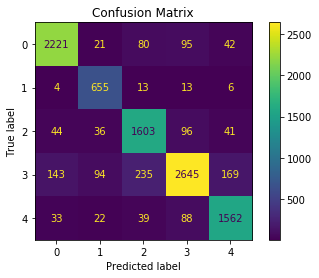

In [20]:
labels = y_random.argmax(axis=1)
cm = confusion_matrix(labels,pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
_=plt.title('Confusion Matrix')

In [87]:
y_random.sum(axis=0)

array([2459,  691, 1820, 3286, 1744])

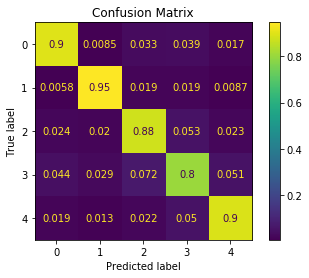

In [47]:
cm_normal = np.true_divide(cm,cm.sum(axis=1).reshape(-1,1))
cm_display = ConfusionMatrixDisplay(cm_normal).plot()
_=plt.title('Confusion Matrix')

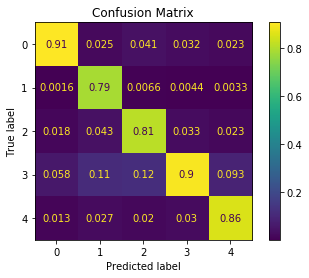

In [81]:
cm_normal = np.true_divide(cm,cm.sum(axis=0).reshape(1,-1))
cm_display = ConfusionMatrixDisplay(cm_normal).plot()
_=plt.title('Confusion Matrix')

In [50]:
print(classification_report(y_random.argmax(axis=1),pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2459
           1       0.79      0.95      0.86       691
           2       0.81      0.88      0.85      1820
           3       0.90      0.80      0.85      3286
           4       0.86      0.90      0.88      1744

    accuracy                           0.87     10000
   macro avg       0.85      0.89      0.87     10000
weighted avg       0.87      0.87      0.87     10000



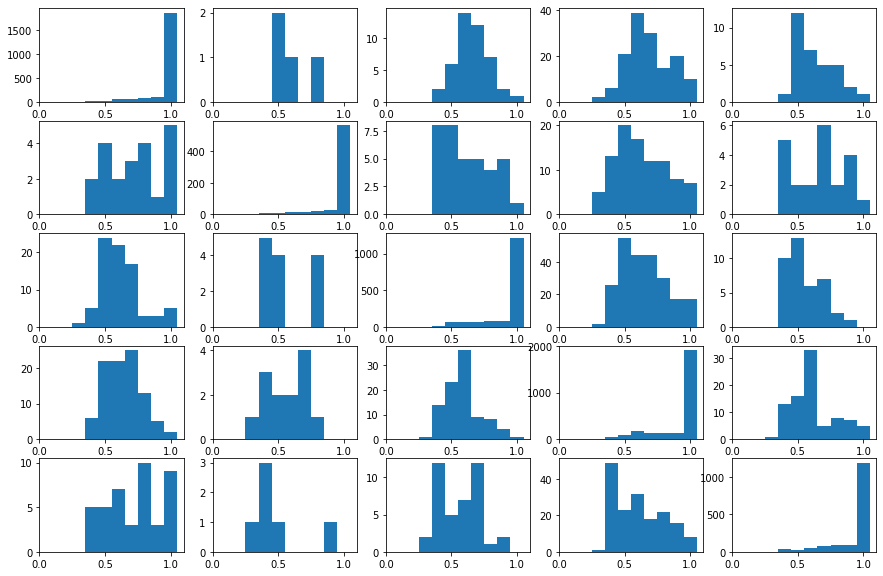

In [80]:
fig, axes = plt.subplots(5,5,figsize=(15,10))
bins_range = np.arange(0,1.1,0.1)
for p in range(5):
    for l in range(5):
        mask = (pred == p) & (labels == l)
        counts,bin_edges = np.histogram(pred_score[mask],bins=bins_range)
        axes[p,l].bar(x=bin_edges[1:],height=counts,width=0.1)

In [84]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(labels, pred_score, n_bins=3)

ValueError: Only binary classification is supported. Provided labels [0 1 2 3 4].

In [88]:
from sklearn.calibration import CalibratedClassifierCV

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 23)                598       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                432       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                209       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 60        
Total params: 1,299
Trainable params: 1,299
Non-trainable params: 0
_________________________________________________________________
